## Astr19 Final Project Part 2

In [239]:
import numpy as np
import sep

In [240]:
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

### Read the image

In [241]:
hdul = fits.open("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")
data = hdul[0].data
hdul.close()

### Show the image

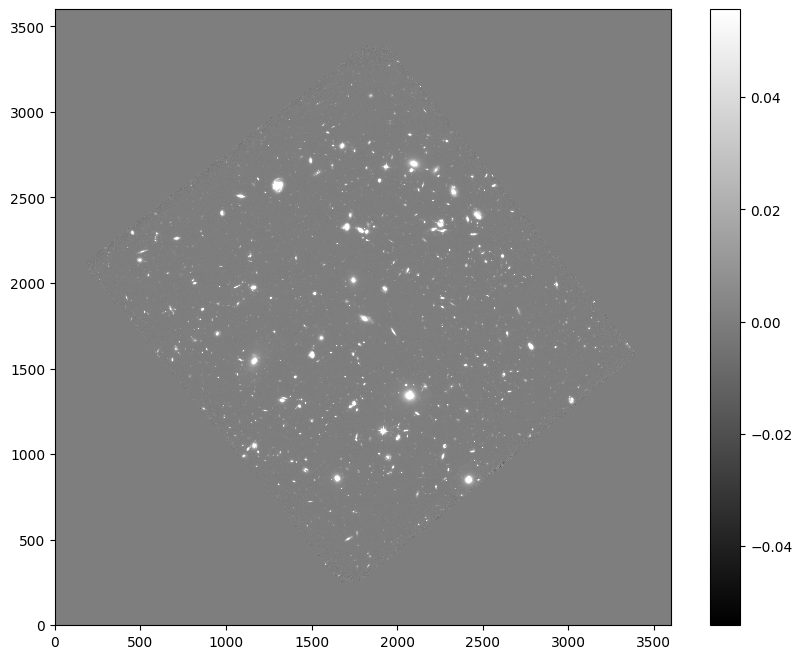

In [242]:
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()
plt.savefig('fits_file_2.png')
plt.show()

### Background subtraction

In [243]:
data = data.byteswap().newbyteorder()

In [244]:
bkg = sep.Background(data)

In [245]:
bkg = sep.Background(data, bw=64, bh=64, fw=3, fh=3)

In [246]:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


In [247]:
bkg_image = bkg.back()

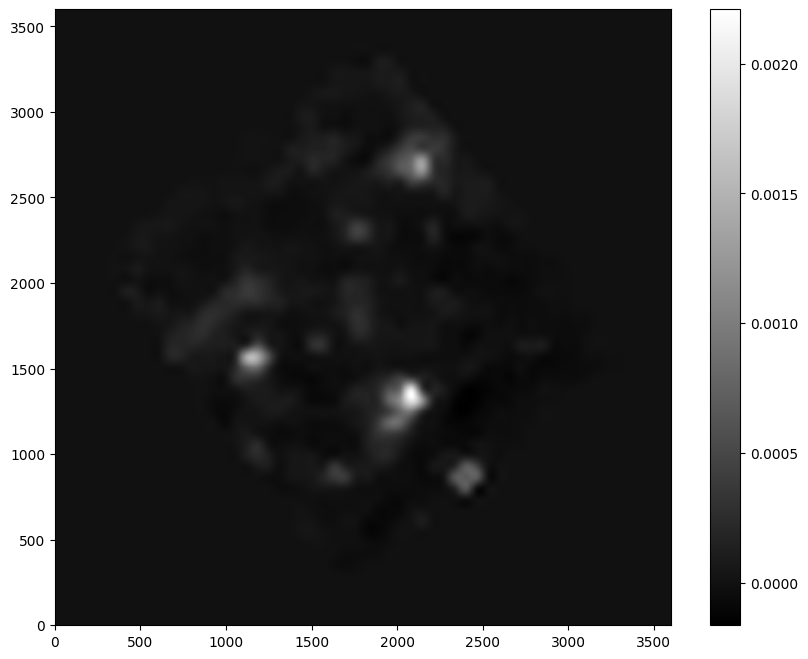

In [248]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('background_2.png')

### Evaluate and show the background noise

In [249]:
bkg_rms = bkg.rms()

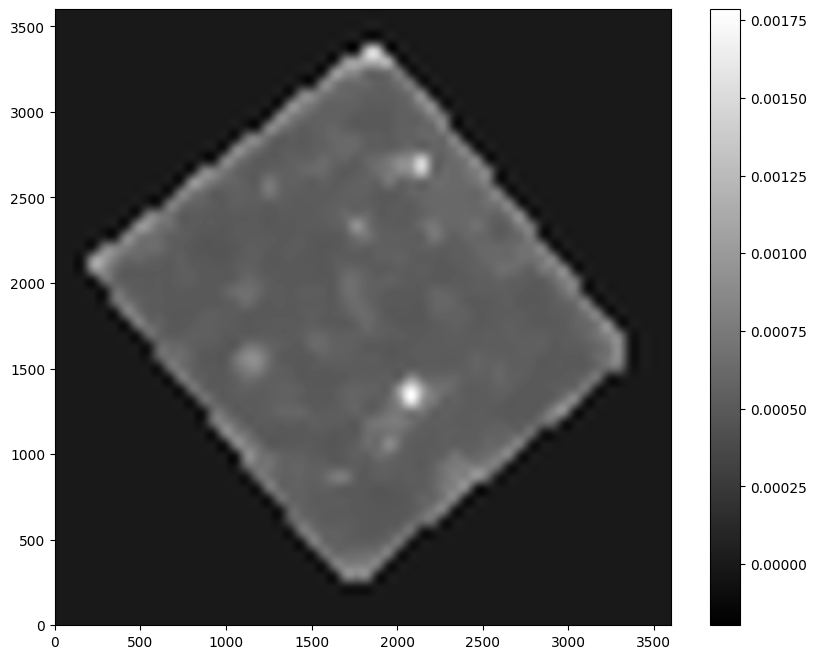

In [250]:
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('background_noise_2.png')

In [251]:
# subtract the background
data_sub = data - bkg

### Object detection

In [252]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

In [253]:
len(objects)

8640

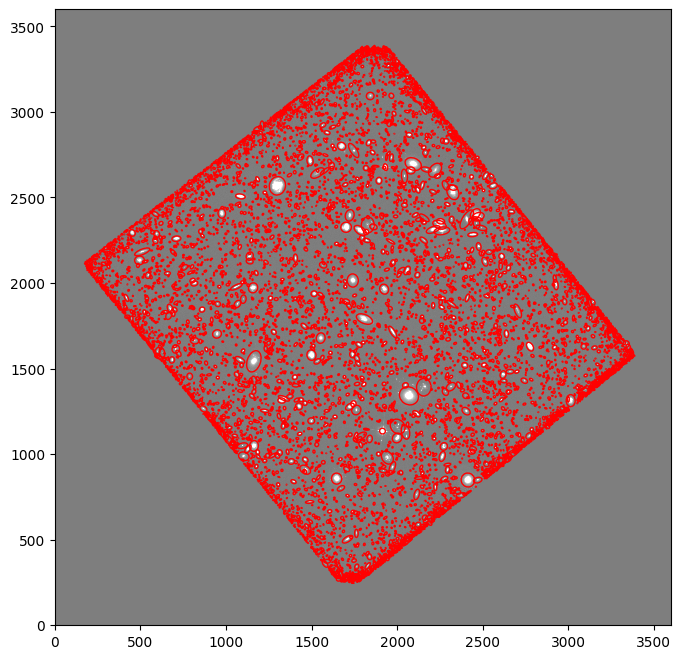

In [254]:
# over-plot the object coordinates
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.savefig('background_subtracted_image_2.png')

In [255]:
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

### Perform aperture photometry

In [256]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [257]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


### Histogram the fluxes

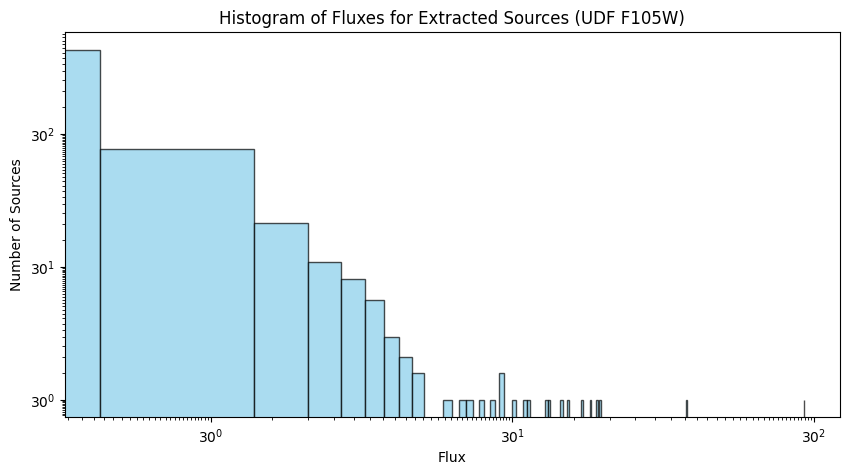

In [258]:
plt.figure(figsize=(10, 5))
plt.hist(flux, bins=600, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Fluxes for Extracted Sources (UDF F105W)')
plt.xscale('log', base=30)
plt.yscale('log', base=30)
plt.xlabel('Flux')
plt.ylabel('Number of Sources')
plt.show()


### Analyze the distribution of fluxes

In [259]:
mean_flux = np.mean(flux)
median_flux = np.median(flux)
std_flux = np.std(flux)
print(f"Mean flux: {mean_flux:.6f}")
print(f"Median flux: {median_flux:.6f}")
print(f"Standard deviation of fluxes: {std_flux:.6f}")


Mean flux: 0.361862
Median flux: 0.030957
Standard deviation of fluxes: 9.243528


In [260]:
deviations_from_mean = [(f - mean_flux) / std_flux for f in flux]

max_deviation = max(deviations_from_mean, key=abs)
outlier_index = deviations_from_mean.index(max_deviation)
outlier_flux = flux[outlier_index]

print(f"The largest outlier flux: {outlier_flux:.6f}")
print(f"The largest outlier is {max_deviation:.2f} standard deviations away from the mean.")

The largest outlier flux: 807.297284
The largest outlier is at index 2066 in the array.
The largest outlier is 87.30 standard deviations away from the mean.


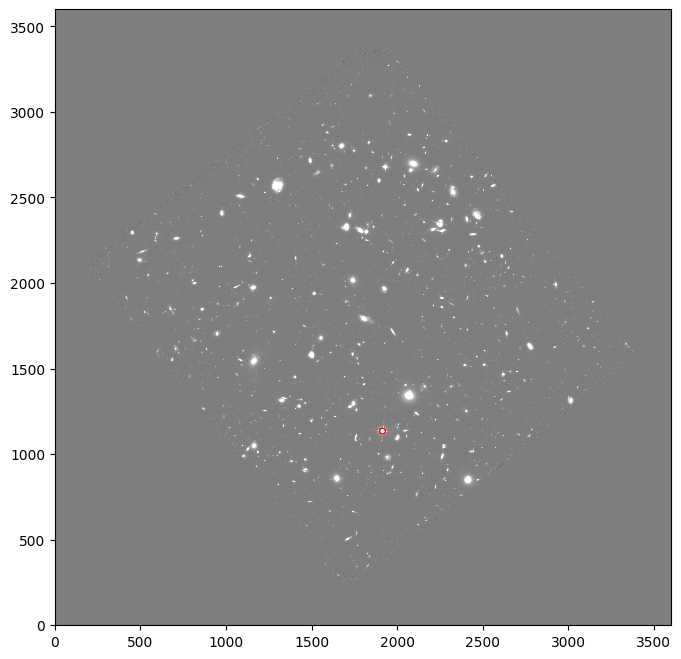

In [265]:
# plot an ellipse for the largest outlier
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

e = Ellipse(xy=(objects['x'][2066], objects['y'][2066]),
            width=6*objects['a'][2066],
            height=6*objects['b'][2066],
            angle=objects['theta'][2066] * 180. / np.pi)
e.set_facecolor('none')
e.set_edgecolor('red')
ax.add_artist(e)

### Make a 3-color false image

In [261]:
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import get_pkg_data_filename

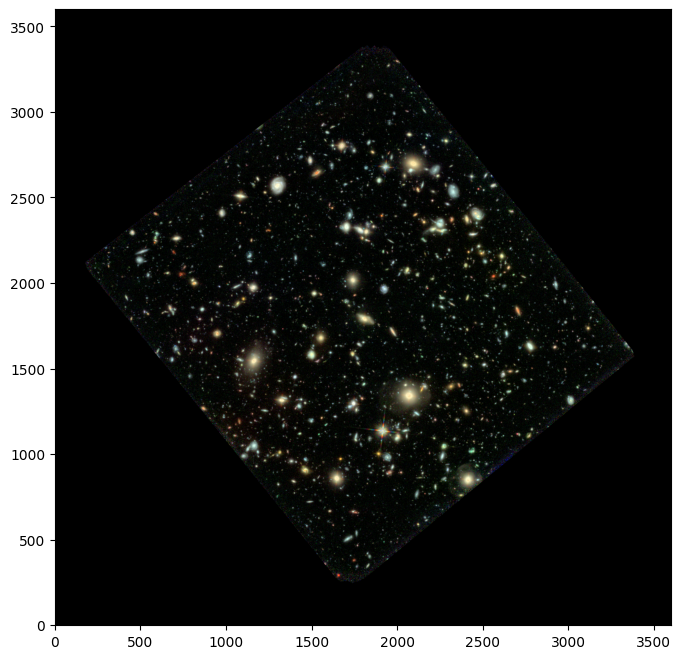

In [262]:
g_name = get_pkg_data_filename('hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits')
r_name = get_pkg_data_filename('hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits')
i_name = get_pkg_data_filename('hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits')
g = fits.getdata(g_name)
r = fits.getdata(r_name)
i = fits.getdata(i_name)

rgb = make_lupton_rgb(i, r, g, Q=6, stretch=0.01, filename="3color_false_image.png")
plt.imshow(rgb, origin='lower')